In [2]:
from metricas import dice_arteria_derecha, dice_arteria_izquierda, dice_arteria_principal, dice_coefficient, dice_promedio,dice_background
from scipy.interpolate import RegularGridInterpolator
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import ConfigProto
from perdidas import dice_coefficient_loss
from keras.models import load_model
from dataloader import DataLoader
from modelo import build_unet
from  keras import optimizers
from keras import utils
import numpy as np
import json
import nrrd
import keras
from metricas import dice_arteria_derecha
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap, ListedColormap

import wandb

import tensorflow as tf

In [3]:
def fix_gpu():
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
fix_gpu()


def rediminesionar(volumen):
    x = np.linspace(0,volumen.shape[0]-1,volumen.shape[0]) 
    y = np.linspace(0,volumen.shape[1]-1,volumen.shape[1]) 
    z = np.linspace(0,volumen.shape[2]-1,volumen.shape[2]) 

    f = RegularGridInterpolator((x,y,z), volumen)
    xn = np.linspace(0,volumen.shape[0]-1,dim[0])
    yn = np.linspace(0,volumen.shape[1]-1,dim[1]) 
    zn = np.linspace(0,volumen.shape[2]-1,dim[2]) 

    new_grid = np.array(np.meshgrid(xn,yn,zn, indexing = 'ij'))
    new_grid = np.moveaxis(new_grid, 0, -1)  #ordena ejes 
    data_new = f(new_grid)

    return data_new

def recorrer(segmentacion,map=None):
    segmentacion = np.asarray(segmentacion)
    segmentacion = segmentacion[~(segmentacion==0).all((2,1))]
    seg = segmentacion
    import math
    columna = 0
    fila = 0
    fig, ax = plt.subplots(4,int(math.ceil(seg.shape[0] / 4)),figsize=(20,10))

    if(set(list(np.unique(seg))) ==  [0,1]):
        map=ListedColormap(["indigo", "yellow"])
    if(set(list(np.unique(seg))) ==  [0,1,2]):
        map=ListedColormap(["indigo", "yellow","blue"])
    if(set(list(np.unique(seg))) ==  [0,1,2,3]):
        map=ListedColormap(["indigo", "yellow","blue","red"])

    #map=ListedColormap(["indigo", "yellow","blue","red","black"])
    
    for indice in range(0,seg.shape[0]):
 
        ax[fila,columna].imshow(seg[indice,:,:], cmap=map)
        ax[fila,columna].set_title("fase {}".format(str(indice)))
        #ax[fila,columna].axis(False)
            
        if(columna == int(math.ceil(seg.shape[0] / 4)) -1):
            columna = 0
            fila+=1
        else:
            columna +=1
        if(fila==5 and columna == 4):
            break
    #plt.show()

2022-11-20 15:10:26.704487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 15:10:26.761313: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-20 15:10:26.761412: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aaronponce
2022-11-20 15:10:26.761436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aaronponce
2022-11-20 15:10:26.761733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.8
2022-11-20 15:10:26.761814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.8
2022-11-20 15:1

In [4]:
dim=(128, 128, 64,1)

directorio_rutas = "../rutas_de_dataset/v2"

conjuntos = directorio_rutas + "/ids.json"
etiquetas = directorio_rutas + "/etiquetas.json"
imagenes  = directorio_rutas + "/imagenes.json"

conjuntos = open(conjuntos)
etiquetas = open(etiquetas)
imagenes = open(imagenes)

conjuntos = json.load(conjuntos)
etiquetas = json.load(etiquetas)
imagenes = json.load(imagenes)

print(conjuntos["test"])
ruta_modelo = "peso_test.h5"

['id-8', 'id-17', 'id-0', 'id-19', 'id-11']


In [5]:
model = load_model(ruta_modelo,custom_objects={"dice_coefficient_loss":dice_coefficient_loss,
                                                    "dice_promedio": dice_promedio,
                                                    "dice_arteria_principal":dice_arteria_principal,
                                                    "dice_arteria_izquierda":dice_arteria_izquierda,
                                                    "dice_arteria_derecha":dice_arteria_derecha})
detecciones = []
true_etiqueta = []
inputs = []
true_etiquetas_no_binarias = []

from monai.transforms import Resized, AsDiscrete
for id in conjuntos["test"]:
    ruta_imagen = imagenes[id] 
    ruta_etiqueta = etiquetas[id]

    imagen, _ = nrrd.read(ruta_imagen)
    imagen = rediminesionar(imagen)

    dims =  imagen.shape
    


    etiqueta_no_binaria, _ = nrrd.read(ruta_etiqueta)
    true_etiquetas_no_binarias.append(etiqueta_no_binaria)


    """
    arteria_principal = etiqueta_no_binaria == 1
    arteria_derecha = etiqueta_no_binaria == 2
    arteria_izquierda = etiqueta_no_binaria == 3

    arteria_principal = np.expand_dims(arteria_principal, axis=0)
    arteria_derecha = np.expand_dims(arteria_derecha,  axis=0)
    arteria_izquierda =  np.expand_dims(arteria_izquierda,  axis=0)



    redim_m = Resized(keys=["arteria_principal","arteria_derecha","arteria_izquierda"],spatial_size=(128,128,64), mode=('area'))
    
    dic_resize = redim_m({"arteria_principal":arteria_principal,
                        "arteria_derecha": arteria_derecha,
                        "arteria_izquierda":arteria_izquierda})

    art_resize_principal = dic_resize["arteria_principal"]    
    art_resize_derecha = dic_resize["arteria_derecha"]
    art_resize_izquierda = dic_resize["arteria_izquierda"]


    label_tronco = art_resize_principal.reshape(128, 128, 64).cpu()
    label_drcho = art_resize_derecha.reshape(128, 128, 64).cpu()
    label_izq = art_resize_izquierda.reshape(128, 128, 64).cpu()

    tronco_bin = (label_tronco > 0.5).numpy().astype(int)

    
    derecho_bin = (label_drcho > 0.5).numpy().astype(int)
    izquierdo_bin = (label_izq > 0.5).numpy().astype(int)

    union_tronco_derecho = (tronco_bin + derecho_bin)
    union_tronco_izquierdo = (tronco_bin + izquierdo_bin)

    if(np.sum(union_tronco_derecho==2) > 0):
        mask = (union_tronco_derecho == 2).astype(int)
        derecho_bin = derecho_bin - mask


    if(np.sum(union_tronco_izquierdo==2) > 0):
        mask = (union_tronco_izquierdo == 2).astype(int)
        izquierdo_bin = izquierdo_bin - mask

    union_derecho_izquierdo = (derecho_bin + izquierdo_bin)

    if(np.sum(union_derecho_izquierdo==2) > 0):
        mask = (union_derecho_izquierdo == 2).astype(int)
        derecho_bin = derecho_bin - mask


    union = tronco_bin + (derecho_bin*2) + (izquierdo_bin*3)

    print("union shape : ",union.shape)
    print("unique: ", np.unique(union))
    recorrer(union)
    plt.close()

    union = np.expand_dims(union, axis=0)
    print(union.shape)


    discret = AsDiscrete(to_onehot=4)
    sig = discret(union)
    sig = np.moveaxis(sig, 0, -1)
    etiqueta_ = sig

    """

      

    etiqueta = utils.to_categorical(etiqueta_no_binaria, num_classes=4)
    etiqueta = rediminesionar(etiqueta)
    etiqueta = (etiqueta > 0.5).astype(int)
    plt.imshow(etiqueta[:,:,20])
    plt.savefig("test1.png")
    plt.close()


    plt.close()
    map=ListedColormap(["indigo", "yellow"])
    fg, ax = plt.subplots(4,5, figsize=(10,10))
    ax[0,0].imshow(imagen[30,:,:],cmap="gray")
    ax[0,1].imshow(imagen[35,:,:],cmap="gray")
    ax[0,2].imshow(imagen[40,:,:],cmap="gray")
    ax[0,3].imshow(imagen[45,:,:],cmap="gray")
    ax[0,4].imshow(imagen[50,:,:],cmap="gray")
    ax[1,0].imshow(imagen[55,:,:],cmap="gray")
    ax[1,1].imshow(imagen[60,:,:],cmap="gray")
    ax[1,2].imshow(imagen[65,:,:],cmap="gray")
    ax[1,3].imshow(imagen[70,:,:],cmap="gray")
    ax[1,4].imshow(imagen[75,:,:],cmap="gray")

    ax[0,0].imshow(etiqueta[30,:,:,2], cmap="jet", alpha=0.3)
    ax[0,1].imshow(etiqueta[35,:,:,2], cmap="jet", alpha=0.3)
    ax[0,2].imshow(etiqueta[40,:,:,2], cmap="jet", alpha=0.3)
    ax[0,3].imshow(etiqueta[45,:,:,2], cmap="jet", alpha=0.3)
    ax[0,4].imshow(etiqueta[50,:,:,2], cmap="jet", alpha=0.3)
    ax[1,0].imshow(etiqueta[55,:,:,2], cmap="jet", alpha=0.3)
    ax[1,1].imshow(etiqueta[60,:,:,2], cmap="jet", alpha=0.3)
    ax[1,2].imshow(etiqueta[65,:,:,2], cmap="jet", alpha=0.3)
    ax[1,3].imshow(etiqueta[70,:,:,2], cmap="jet", alpha=0.3)
    ax[1,4].imshow(etiqueta[75,:,:,2], cmap="jet", alpha=0.3)


    ax[2,0].imshow(imagen[30,:,:],cmap="gray")
    ax[2,1].imshow(imagen[35,:,:],cmap="gray")
    ax[2,2].imshow(imagen[40,:,:],cmap="gray")
    ax[2,3].imshow(imagen[45,:,:],cmap="gray")
    ax[2,4].imshow(imagen[50,:,:],cmap="gray")
    ax[3,0].imshow(imagen[55,:,:],cmap="gray")
    ax[3,1].imshow(imagen[60,:,:],cmap="gray")
    ax[3,2].imshow(imagen[65,:,:],cmap="gray")
    ax[3,3].imshow(imagen[70,:,:],cmap="gray")
    ax[3,4].imshow(imagen[75,:,:],cmap="gray")

    plt.savefig("test3.png")
    plt.close()

    print("etiqueta shape: {}".format(etiqueta.shape))
    print("imagen shape: {}".format(imagen.shape))

    #print("etiqueta",np.unique(etiqueta[5,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[10,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[15,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[20,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[25,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[30,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[35,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[40,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[45,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[50,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[55,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[60,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[65,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[70,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[75,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[80,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[85,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[90,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[95,:,:,1]))
    #print("etiqueta",np.unique(etiqueta[100,:,:,1]))


    imagen = np.expand_dims(imagen, axis=3)
    imagen = np.expand_dims(imagen, axis=0)

    etiqueta = np.expand_dims(etiqueta, axis=0)

    output = model.predict(
                    imagen,
                    verbose="auto",
                    workers=1,
                )
    #debug
    #output = np.random.randint(2, size=(1, 128, 128, 64, 4)).astype(np.float32)
    #print("Etiqueta unique: {} shape:{} ".format(np.unique(etiqueta.astype(np.float32)), etiqueta.shape))

    output = (output > 0.5).astype(np.float32)

    #print("Output unique: {} shape: {}".format(np.unique(output),output.shape))
    
    dice_derecha = dice_arteria_derecha(output,output)
    dice_principal = dice_arteria_principal(output,output)
    dice_izquierda = dice_arteria_izquierda(output,output)
    dice_back = dice_background(output,output)
    dice_prom = dice_promedio(output,output)

    #dice_principal = dice_arteria_principal(etiqueta.astype(np.float32),output)
    #dice_izquierda = dice_arteria_izquierda(etiqueta.astype(np.float32),output)
    #dice_back = dice_background(etiqueta.astype(np.float32),output)
    #dice_prom = dice_promedio(etiqueta.astype(np.float32),output)

    print("-----Resumen Test IMG: {}:------\n - . Dice Principal: {} \n - . Dice Derecha: {}\n - . Dice Izquierdo: {}\n - . Dice Promedio: {}\n - . Dice background: {} ".format(
                                        id,dice_principal.numpy(),dice_derecha.numpy(),dice_izquierda.numpy(),dice_prom.numpy(),dice_back.numpy()))

    inputs.append(np.array(imagen[0]).reshape(dims))
    detecciones.append(np.array(output[0]).reshape(128,128,64,4))
    true_etiqueta.append(np.array(etiqueta[0]).reshape(128,128,64,4))

    #print("true_etiqueta: {}".format(true_etiqueta[0].shape))
    #print(np.max(detecciones[0][:,:,32,2]))
    #break

/home/aaronponce/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


etiqueta shape: (128, 128, 64, 4)
imagen shape: (128, 128, 64)
1/1 [==============================] - 9s 9s/step
dice_arteria_izquierda
dice_arteria_izquierda
-----Resumen Test IMG: id-8:------
 - . Dice Principal: 0.0 
 - . Dice Derecha: 0.0
 - . Dice Izquierdo: 1.0
 - . Dice Promedio: 0.3333333432674408
 - . Dice background: 0.0 
etiqueta shape: (128, 128, 64, 4)
imagen shape: (128, 128, 64)
1/1 [==============================] - 9s 9s/step
dice_arteria_izquierda
dice_arteria_izquierda
-----Resumen Test IMG: id-17:------
 - . Dice Principal: 1.0 
 - . Dice Derecha: 1.0
 - . Dice Izquierdo: 1.0
 - . Dice Promedio: 1.0
 - . Dice background: 1.0 
etiqueta shape: (128, 128, 64, 4)
imagen shape: (128, 128, 64)
1/1 [==============================] - 9s 9s/step
dice_arteria_izquierda
dice_arteria_izquierda
-----Resumen Test IMG: id-0:------
 - . Dice Principal: 0.0 
 - . Dice Derecha: 0.0
 - . Dice Izquierdo: 1.0
 - . Dice Promedio: 0.3333333432674408
 - . Dice background: 0.0 
etiqueta sha

In [67]:
wandb.init(settings=wandb.Settings(start_method="fork"))

indice,63
_runtime,78
_timestamp,1668985035
_step,319


indice,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
class_labels = {
    0: "Background",
    1: "Art. pulmonar principal",
    2: "Art. pulmonar derecha",
    3: "Art. pulmonar izquierda"
    }

img shape:  (128, 128)
shape bin:  (128, 128)


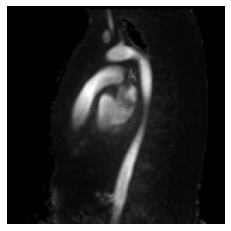

In [20]:
img = inputs[0][:,:,32] * 255
print("img shape: ",img.shape)
print("shape bin: ",true_etiqueta[0][:,:,32,1].shape)

#fig = plt.figure(figsize=(128,128), dpi=60) # in inches
#ax = fig.add_axes([0, 0, 1, 1])  # span the whole figure
#ax.set_axis_off()
#ax.imshow(img, cmap="gray")

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.imsave("image.png",img,cmap="gray")


#fig, ax = plt.subplots(1,2, figsize=(10,10))
#ax[0].imshow(img, cmap="gray")
#ax[1].imshow(true_etiqueta[0][:,:,32,1]*255)
#
#np.unique(true_etiqueta[0][:,:,32,1])



img (128, 128, 64),y_true (128, 128, 64, 4),y_pred :(128, 128, 64, 4)
(128, 128, 64)
id  0
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  1
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  2
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  3
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  4
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  5
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  6
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  7
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  8
(128, 128)
(128, 128)
(128, 128)
np unique ground_truth:  [0]
np unique predictions:  [0.]
id  9
(128, 128)
(128, 128)
(128, 128)
np 

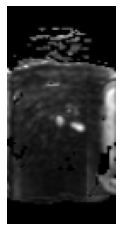

In [68]:

#mask_img = wandb.Image("image.png", masks={
#            "predictions": {
#                "mask_data": detecciones[0][:,:,32,2],
#                "class_labels": class_labels
#            },
#            "ground_truth" : {
#                    "mask_data" : true_etiqueta[0][:,:,32,1],
#                    "class_labels" : class_labels
#                }
#
#        })
#
#wandb.log({"test":mask_img})
import time

class_labels = {
    0: "Background",
    1: "Art. pulmonar principal",
    2: "Art. pulmonar derecha",
    3: "Art. pulmonar izquierda"
    }

nombre_imagenes = ["nombre_00","nombre_01","nombre_02","nombre_03","nombre_04"]

for img,y_true,y_pred,nombre_imagen in zip(inputs,true_etiqueta,detecciones,nombre_imagenes):
    print("img {},y_true {},y_pred :{}".format(img.shape,y_true.shape,y_pred.shape))

    print(img.shape)

    # Sagital
    for id in range(0,img.shape[2]):
        print("id ",id)
        print(img[:,:,id].shape)
        imagen = img[:,:,id] * 255

        plt.imshow(imagen, cmap="gray")
        plt.axis('off')
        plt.imsave("image.png",imagen,cmap="gray")
        time.sleep(0.2)

        print(y_true[:,:,id,1].shape)
        print(y_pred[:,:,id,1].shape)


        ground_truth = y_true[:,:,id,1] +y_true[:,:,id,2]*2 + y_true[:,:,id,3]*3 #+ y_true[:,:,id,4]
        predictions = y_pred[:,:,id,1] + y_pred[:,:,id,2]*2 + y_pred[:,:,id,3]*3 #+ y_pred[:,:,id,4]


        print("np unique ground_truth: ",np.unique(ground_truth))
        print("np unique predictions: ",np.unique(predictions))

        mask_img = wandb.Image("image.png", masks={
            "predictions": {
                "mask_data": predictions,
                "class_labels": class_labels
            },
            "ground_truth" : {
                    "mask_data" : ground_truth,
                    "class_labels" : class_labels
                }
            })
        
        wandb.log({nombre_imagen+"_sagital":mask_img})


    # Coronal
    #"""
    for id in range(0,img.shape[1]):
        print("id ",id)
        print(img[:,id,:].shape)
        imagen = img[:,id,:] * 255

        plt.imshow(imagen, cmap="gray")
        plt.axis('off')
        plt.imsave("image.png",imagen,cmap="gray")
        time.sleep(0.2)

        print(y_true[:,id,:,1].shape)
        print(y_pred[:,id,:,1].shape)


        ground_truth = y_true[:,id,:,1] +y_true[:,id,:,2]*2 + y_true[:,id,:,3]*3 #+ y_true[:,id,:,4]
        predictions = y_pred[:,id,:,1] + y_pred[:,id,:,2]*2 + y_pred[:,id,:,3]*3 #+ y_pred[:,id,:,4]


        print("np unique ground_truth: ",np.unique(ground_truth))
        print("np unique predictions: ",np.unique(predictions))

        mask_img = wandb.Image("image.png", masks={
            "predictions": {
                "mask_data": predictions,
                "class_labels": class_labels
            },
            "ground_truth" : {
                    "mask_data" : ground_truth,
                    "class_labels" : class_labels
                }
            })
        
        wandb.log({nombre_imagen+"_coronal":mask_img})


    for id in range(0,img.shape[0]):
        print("id ",id)
        print(img[id,:,:].shape)
        imagen = img[id,:,:] * 255

        plt.imshow(imagen, cmap="gray")
        plt.axis('off')
        plt.imsave("image.png",imagen,cmap="gray")
        time.sleep(0.2)

        print(y_true[id,:,:,1].shape)
        print(y_pred[id,:,:,1].shape)


        ground_truth = y_true[id,:,:,1] +y_true[id,:,:,2]*2 + y_true[id,:,:,3]*3 #+ y_true[id,:,:,4]
        predictions = y_pred[id,:,:,1] + y_pred[id,:,:,2]*2 + y_pred[id,:,:,3]*3 #+ y_pred[id,:,:,4]


        print("np unique ground_truth: ",np.unique(ground_truth))
        print("np unique predictions: ",np.unique(predictions))

        mask_img = wandb.Image("image.png", masks={
            "predictions": {
                "mask_data": predictions,
                "class_labels": class_labels
            },
            "ground_truth" : {
                    "mask_data" : ground_truth,
                    "class_labels" : class_labels
                }
            })
        
        wandb.log({nombre_imagen+"_axial":mask_img})
    #"""    



    


In [32]:
len(inputs)

5

In [11]:
z.get_size()

NameError: name 'z' is not defined